In [1]:
from pathlib import Path
import os

import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from src.model_dino.tf_data import get_tf_data, RandomStandardization
from src.data.tf_data_hdf5 import get_tf_data as get_tf_data_seg
from src.models.models import UnetLight, UnetLightDecorrelated
from src.data.utils import get_split

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
h5_file = h5py.File("../data/processed/hdf5_2d/data_selected_slices.hdf5", "r")
clinical_df = pd.read_csv(
    "../data/clinical_info_with_lung_info.csv").set_index("patient_id")

In [3]:
ids_train, ids_val, ids_test = get_split(0)

In [4]:
preprocessor_nrdm = RandomStandardization(p=0.0)
f_nrdm = lambda x, y, plc_status, patient: (preprocessor_nrdm(x), y)
ds_train = get_tf_data_seg(
    h5_file,
    clinical_df,
    patient_list=ids_train,
    n_channels=2,
    random_slice=False,
    center_on="GTVt",
    random_position=False,
    shuffle=True,
).map(f_nrdm).cache().batch(100)


In [5]:
ds_test = get_tf_data_seg(
    h5_file,
    clinical_df,
    patient_list=ids_test,
    n_channels=2,
    random_slice=False,
    center_on="GTVt",
    random_position=False,
    shuffle=True,
).map(f_nrdm).cache().batch(100)


In [6]:
for images, masks in ds_train.take(1).as_numpy_iterator():
    pass

In [7]:
for images_test, masks_test in ds_test.take(1).as_numpy_iterator():
    pass

In [8]:
masks.shape

(50, 256, 256, 4)

In [9]:
# model_t = UnetLight(output_channels=100, last_activation="linear")
# model_s = UnetLight(output_channels=100, last_activation="linear")

# model_t = UnetLightDecorrelated(output_channels=100, last_activation="linear")
# model_s = UnetLightDecorrelated(output_channels=100, last_activation="linear")

In [10]:
inputs = tf.keras.Input(shape=(256, 256, 2))
x_dino = UnetLight(output_channels=100,
                   last_activation="linear",
                   name="student_unet")(inputs)
model_r = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.nn.softmax(x / 0.1)),
    tf.keras.layers.Conv2D(256, 1, activation="relu"),
    tf.keras.layers.Conv2D(2, 1, activation="linear")
])

x_r = model_r(x_dino)
model_s = tf.keras.Model(inputs=inputs, outputs=[x_dino, x_r])


In [11]:
epoch = 99

In [12]:
# model_s.load_weights(f"../models/dino/UnetLightsplit_0__ovrsmpl_False__20220308-075414/checkpoints/model_s/epoch_{epoch}")
# model_t.load_weights(f"../models/dino/UnetLightsplit_0__ovrsmpl_False__20220308-075414/checkpoints/model_t/epoch_{epoch}")

# model_s.load_weights(f"../models/dino/UnetLightDecorrelatedsplit_0__ovrsmpl_False__20220308-103158/checkpoints/model_s/epoch_{epoch}")
# model_t.load_weights(f"../models/dino/UnetLightDecorrelatedsplit_0__ovrsmpl_False__20220308-103158/checkpoints/model_t/epoch_{epoch}")

model_s.load_weights(f"../models/dino/UnetLightsplit_0__ovrsmpl_False__with_reconstruction__20220308-194724/checkpoints/model_s/epoch_{epoch}")
# model_s.load_weights(f"../models/dino/UnetLightDecorrelatedsplit_0__ovrsmpl_False__with_reconstruction__20220308-194410/checkpoints/model_s/epoch_{epoch}")
model_s = model_s.get_layer("student_unet")

In [13]:
def power(y_pred):
    return np.sqrt(np.mean(y_pred**2, axis=(0, 1, 2)))

In [14]:
preds = tf.nn.softmax(model_s(images) / 0.1 ).numpy()
# preds = model_s(images).numpy()

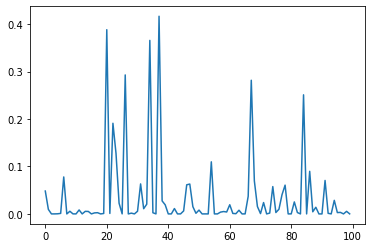

In [15]:
plt.plot(power(preds))

In [16]:
feature_index = np.where(power(preds)>0.01)[0]

In [17]:
feature_index

array([ 0,  6, 20, 22, 23, 24, 26, 31, 32, 33, 34, 37, 38, 39, 42, 46, 47,
       48, 54, 60, 66, 67, 68, 69, 71, 74, 77, 78, 81, 84, 86, 88, 91, 94])

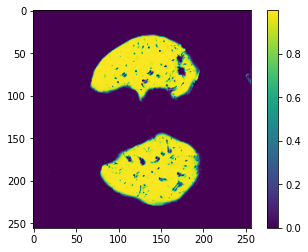

In [53]:
plt.imshow(preds[18, :, :,37])
plt.colorbar()


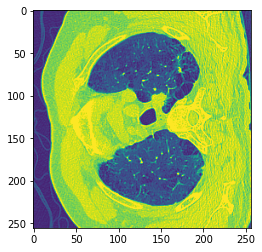

In [54]:
plt.imshow(images[18,:, :, 0])

In [55]:
# classifier = make_pipeline(StandardScaler(), SVC(verbose=2))
classifier = RandomForestClassifier(verbose=2, n_jobs=20)


In [56]:
x_train = np.reshape(preds, [-1, 100])
y_train = np.reshape(masks[..., 0], [
    -1,
])


In [57]:
# positions = np.where(masks[:, :, :, 2] != 0)
# indices = np.arange(len(positions[0]))
# np.random.shuffle(indices)
# indices = indices[:20000]

In [58]:
# x_train = preds[positions[0][indices], positions[1][indices], positions[2][indices], :]
# y_train = masks[positions[0][indices], positions[1][indices], positions[2][indices], 0]


In [59]:
# positions = np.where(masks[:, :, :, 2] + masks[..., 0] == 0)
# indices = np.arange(len(positions[0]))
# np.random.shuffle(indices)
# indices = indices[:20000]

In [60]:
# x_train = np.concatenate([x_train, preds[positions[0][indices], positions[1][indices], positions[2][indices], :]], axis=0)
# y_train = np.concatenate([y_train, masks[positions[0][indices], positions[1][indices], positions[2][indices], 0]], axis=0)

In [61]:
# positions = np.where(masks[:, :, :, 0]  != 0)

In [62]:
# x_train = np.concatenate(
#     [x_train, preds[positions[0], positions[1], positions[2], :]], axis=0)
# y_train = np.concatenate(
#     [y_train, masks[positions[0], positions[1], positions[2], 0]], axis=0)


In [63]:
feature_index

array([ 0,  6, 20, 22, 23, 24, 26, 31, 32, 33, 34, 37, 38, 39, 42, 46, 47,
       48, 54, 60, 66, 67, 68, 69, 71, 74, 77, 78, 81, 84, 86, 88, 91, 94])

In [64]:
x_train = x_train[:,feature_index]

In [65]:
x_train.shape

(3276800, 34)

In [66]:
y_train.shape

(3276800,)

In [67]:
classifier.fit(x_train, y_train)

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100building tree 17 of 100

building tree 18 of 100
building tree 19 of 100

building tree 20 of 100


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:   13.7s


building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62

[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:  1.5min finished


RandomForestClassifier(n_jobs=20, verbose=2)

In [68]:
images_test.shape

(46, 256, 256, 2)

In [69]:
preds_seg = np.reshape(
    classifier.predict(
        np.reshape(tf.nn.softmax(model_s(images_test) / 0.1), [-1, 100])[:, feature_index]),
    [46, 256, 256])
# preds_seg = np.reshape(
#     classifier.predict(
#         np.reshape(model_s(images_test), [-1, 100])[:, feature_index[0]]),
#     [46, 256, 256])


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    2.1s finished


In [70]:
preds_seg.shape

(46, 256, 256)

In [103]:
b = 26

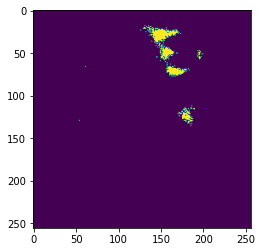

In [104]:
plt.imshow(preds_seg[b, :, :])


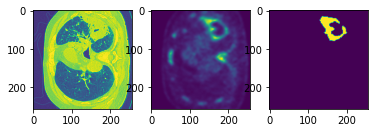

In [105]:
plt.subplot(131)
plt.imshow(images_test[b, :, :, 0])
plt.subplot(132)
plt.imshow(images_test[b, :, :, 1])
plt.subplot(133)
plt.imshow(masks_test[b, :, :, 0])
